In [48]:
!pip install fastai --upgrade
!pip install nbdev
!pip install azure-cognitiveservices-search-imagesearch

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.6)


In [49]:
from fastai.vision.all import *
from utils import *
matplotlib.rc('image', cmap='Greys')

In [50]:
# Get MNIST Sample data

path = untar_data(URLs.MNIST_SAMPLE)

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

valid_3_tens = torch.stack([tensor(Image.open(o))
                              for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                              for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

## MNIST Loss Function

In [51]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [52]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [53]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [54]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [55]:
weights = init_params((28*28,1))

In [56]:
bias = init_params(1)

In [57]:
(train_x[0]*weights.T).sum() + bias

tensor([5.7684], grad_fn=<AddBackward0>)

In [58]:
def linear1(xb):
  return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 5.7684],
        [-1.3302],
        [-1.0949],
        ...,
        [ 5.4557],
        [-9.6040],
        [-3.9362]], grad_fn=<AddBackward0>)

In [59]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [ True]])

In [60]:
corrects.float().mean().item()

0.5969667434692383

In [61]:
weights[0] *= 1.0001

In [62]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5969667434692383

In [63]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

In [64]:
def mnist_loss(predictions, targets):
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [65]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [66]:
mnist_loss(prds, trgts)

tensor(0.4333)

In [67]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.2333)

### Sigmoid

In [68]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

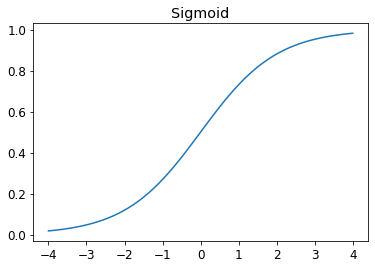

In [69]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [70]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

In [71]:
# DataLoader can take in any Python collection and turn it into an iterator
# over many batches

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3,  2, 10,  9, 13]),
 tensor([14,  6,  8,  0,  1]),
 tensor([ 7,  4,  5, 12, 11])]

In [72]:
# A collection of tuples of independent and dependent variables in PyTorch
# is a Dataset
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [73]:
dl = DataLoader(ds, batch_size=6, shuffle=True)

In [74]:
list(dl)

[(tensor([ 3, 16, 17,  8,  7,  2]), ('d', 'q', 'r', 'i', 'h', 'c')),
 (tensor([10, 22,  4, 14, 25, 15]), ('k', 'w', 'e', 'o', 'z', 'p')),
 (tensor([ 1, 12, 19,  5,  9, 11]), ('b', 'm', 't', 'f', 'j', 'l')),
 (tensor([ 0, 23, 21, 13, 18, 20]), ('a', 'x', 'v', 'n', 's', 'u')),
 (tensor([ 6, 24]), ('g', 'y'))]

### Putting it all together

In code, our process will be implemented like this for each epoch:

```
for x, y in dl:
  pred = model(x)
  loss = loss_func(pred, y)
  loss.backward()
  parameters -= parameters.grad * lr
```

In [75]:
weights = init_params((28*28,1))
bias = init_params(1)


In [76]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [77]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [78]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [79]:
preds = linear1(batch)
preds

tensor([[-6.0790],
        [-2.2834],
        [-2.4200],
        [-4.3862]], grad_fn=<AddBackward0>)

In [80]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9528, grad_fn=<MeanBackward0>)

In [81]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0063), tensor([-0.0433]))

In [82]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [83]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0126), tensor([-0.0867]))

In [84]:
# What if we call it twice?
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0189), tensor([-0.1300]))

In [85]:
weights.grad.zero_()
bias.grad.zero_();

In [86]:
def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

In [87]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [88]:
def batch_accuracy(xb,yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

In [89]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [90]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [91]:
validate_epoch(linear1)

0.4196

In [92]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6132

In [93]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.8393 0.912 0.9398 0.9486 0.9554 0.9603 0.9612 0.9656 0.9676 0.9701 0.972 0.9725 0.9745 0.9754 0.9754 0.9769 0.9774 0.9769 0.9779 0.9779 

## Creating an optimizer

In [94]:
linear_model = nn.Linear(28*28,1)

In [95]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [96]:
class BasicOptim:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad = None

In [97]:
opt = BasicOptim(linear_model.parameters(), lr)

In [98]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [99]:
validate_epoch(linear_model)

0.543

In [100]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [101]:
train_model(linear_model, 20)

0.4932 0.8213 0.8447 0.915 0.9335 0.9472 0.9555 0.9628 0.9657 0.9672 0.9692 0.9716 0.9736 0.975 0.976 0.9765 0.9775 0.978 0.9785 0.9789 

In [102]:
# SGD class does same thing as BasicOptim
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.6894 0.8657 0.9199 0.937 0.9521 0.9565 0.9633 0.9657 0.9677 0.9706 0.9726 0.9745 0.975 0.976 0.977 0.9775 0.978 0.978 0.9785 

In [103]:
# fastai provides Learner.fit, which can be u sed instead of train_model
# To create learner, we first need to create a DataLoaders object by
# passing in training and validation DataLoaders
dls = DataLoaders(dl, valid_dl)

# To create learner without using an application (cnn_learner), we pass in
# DataLoaders, model, optimization function, loss function, and optional
# metrics to print
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [104]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637136,0.503349,0.495584,00:00
1,0.483434,0.208136,0.819921,00:00
2,0.178845,0.171965,0.844946,00:00
3,0.079119,0.104468,0.913641,00:00
4,0.042428,0.076757,0.933268,00:00
5,0.028091,0.061656,0.946516,00:00
6,0.022178,0.052233,0.955348,00:00
7,0.019528,0.045953,0.963199,00:00
8,0.018168,0.041537,0.965653,00:00
9,0.017341,0.038284,0.967615,00:00


## Adding a Nonlinearity

In [105]:
def simple_net(xb):
  res = xb@w1 + b1
  res = res.max(tensor(0.0)) # ReLU
  res = res@w2 + b2
  return res

In [106]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

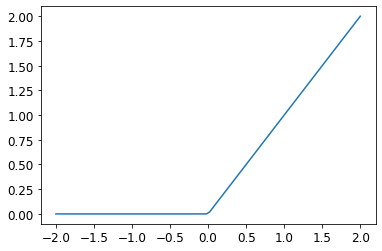

In [107]:
plot_function(F.relu)

In [108]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [109]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [110]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.282915,0.422194,0.504416,00:00
1,0.138270,0.219160,0.816487,00:00
2,0.077973,0.112066,0.916094,00:00
3,0.052131,0.076443,0.942100,00:00
4,0.040011,0.059904,0.957311,00:00
5,0.033731,0.050593,0.964181,00:00
6,0.030070,0.044709,0.965653,00:00
7,0.027660,0.040679,0.967615,00:00
8,0.025907,0.037746,0.968597,00:00
9,0.024544,0.035507,0.970069,00:00


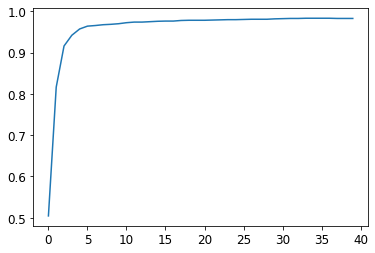

In [111]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [112]:
# View final accuracy
learn.recorder.values[-1][2]

0.982826292514801

In [114]:
# Training 18-layer model using same approach in Chapter 1

dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.083060,0.016565,0.995093,00:21


# Questionnaire (end of Chapter 4)

Do you need to know how to calculate gradients yourself? No. We just need to know what it means.

Why can’t we use accuracy as a loss function? It is unclear how changes in accuracy can be used to improve model parameters.

Draw the sigmoid function. What is special about its shape? It looks like S. It converts any real number to the range (0,1). It is very good for getting our parameters into scales that work with deep learning.

What is the difference between a loss function and a metric? Loss function is used to assess model's performance and the gradient (derivative of loss function wrt model's parameters) can be used to update weights. Accuracy, on the other hand, is something that we humans care about. Accuracy may not change even if loss and weight parameters change.

What is the function to calculate new weights using a learning rate? This is the optimization step.

What does the DataLoader class do? It takes any Python collection and turns it into an iterator over many batches.

Write pseudocode showing the basic steps taken in each epoch for SGD.

```
for x, y in dl:
  pred = model(x)
  loss = loss_func(pred, y)
  loss.backward()
  parameters -= parameters.grad * lr
```

Create a function that, if passed two arguments [1,2,3,4] and 'abcd', returns [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]. What is special about that output data structure?

```
def create_zip(a,b):
  return list(zip(a,b)) 
```

This output data structure is needed for DataLoaders.

What does view do in PyTorch? It reshapes a tensor.

What are the bias parameters in a neural network? Why do we need them? Bias is like the w in y=wx+b. It makes the linear function more flexible.

What does the @ operator do in Python? It does matrix multiplication

What does the backward method do? It calculates the gradients.

Why do we have to zero the gradients? Otherwise, we will continue to accumulate gradients.

What information do we have to pass to Learner? DataLoaders, model, optimization function, loss function, and optional metrics to print.

Show Python or pseudocode for the basic steps of a training loop.

```
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')
```

What is ReLU? Draw a plot of it for values from -2 to +2. ReLU takes max between a value and 0. 

What is an activation function? It is a non-linearity usually placed between linear layers.

What’s the difference between F.relu and nn.ReLU? F.relu is the function while nn.ReLU is the module.

The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more? We do it for performance. A deeper model does not require as many parameters and leads to more quick model training and less memory usage.

In [115]:
list(zip([1,2,3,4], 'abcd'))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]